# Creation of Gif

### Installation
In order to run the following script you'll need to install a few python lybrary.
#### Rasterio
Follow instruction on:
https://rasterio.readthedocs.io/en/stable/installation.html
#### Window
In order to only get part of the whole tif file: https://rasterio.readthedocs.io/en/stable/api/rasterio.windows.html
```
pip install window
```
#### PyCRS
```
conda install --yes --prefix {sys.prefix} -c conda-forge pycrs
```
#### ffmpeg 
To visualise the gif file created
```
conda install --yes --prefix {sys.prefix} -c conda-forge ffmpeg
```
#### Other 
There might be other things you'll have to install and didn't have to cause it was already unstall on my machine, please feel free to update the list.

### Set up

You'll have to download some of the .TIF file and update the `in_files` array with their paths.
You also need the grand truth `.shp` file and update "shape_file" with its path.
I've randomly pick up the field 58 in the list because it was big enough so we can see something but you can also update that if you want.

In [2]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
import pycrs
from matplotlib import pyplot
from rasterio.plot import show_hist
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.mask import mask
from rasterio.plot import plotting_extent

# Gif
import imageio
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [3]:
#Set up

url = "http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed/ard/backscatter/2018"

in_files = [
    [url + "/01/07/S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","January 2018"],
    [url + "/02/06/S1B_20180206_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1B_20180206_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","February 2018"],
    [url + "/03/02/S1B_20180302_30_asc_175747_175812_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1B_20180302_30_asc_175747_175812_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","March 2018"],
    [url + "/04/07/S1B_20180407_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1B_20180407_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","April 2018"],
    [url + "/05/01/S1B_20180501_30_asc_175809_175834_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1B_20180501_30_asc_175809_175834_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","May 2018"],
    [url + "/06/12/S1A_20180612_30_asc_175839_175904_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1A_20180612_30_asc_175839_175904_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","June 2018"],
    [url + "/07/06/S1A_20180706_30_asc_175840_175905_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1A_20180706_30_asc_175840_175905_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","July 2018"],
    [url + "/08/11/S1A_20180811_30_asc_175843_175908_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1A_20180811_30_asc_175843_175908_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","August 2018"],
    [url + "/09/04/S1A_20180904_30_asc_175844_175909_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1A_20180904_30_asc_175844_175909_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif","September 2018"]
]

shape_file = "fields.shp"

In [65]:
# One way to go through each tif files on the serveur

from bs4 import BeautifulSoup
import requests

all_server_files = []
server = 'http://gws-access.ceda.ac.uk'
url = server + '/public/defra_eo/sentinel/1/processed/ard/backscatter/2018'
ext = 'tif'

def listTiffFiles(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def listDirs(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith('/') and node.text != "Parent Directory"]

idx = 0
for dir in listDirs(url):
    for subdir in listDirs(dir):
        for subdir2 in listDirs(subdir):
            for url in listTiffFiles(subdir2, ext):
                filename = url[url.rfind("/")+1:]
                file_elem = filename.split("_")
                date = file_elem[1]
                year = date[0:4]
                month = date[4:6]
                day = date[6:]
                file_info = {
                    "year": year,
                    "month": month,
                    "day": day,
                    "url": url                    
                }
                all_server_files.append(file_info)
                idx += 1
all_server_files

[{'year': '2018',
  'month': '01',
  'day': '01',
  'url': 'http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed/ard/backscatter/2018/01//01//S1B_20180101_30_asc_175749_175814_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1B_20180101_30_asc_175749_175814_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'},
 {'year': '2018',
  'month': '01',
  'day': '01',
  'url': 'http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed/ard/backscatter/2018/01//01//S1B_20180101_30_asc_175814_175839_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1B_20180101_30_asc_175814_175839_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'},
 {'year': '2018',
  'month': '01',
  'day': '02',
  'url': 'http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed/ard/backscatter/2018/01//02//S1A_20180102_132_asc_175018_175043_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1A_20180102_132_asc_175018_175043_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'},
 {'year': '2018',
  'month': '01',
  'day': '02',
  'url': 'http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed

In [10]:
field_num = 0

In [5]:
# Create Bbox

minx, miny = 361044.2,619013.4 
maxx, maxy = 383132.1,635928.0
bbox = box(minx, miny, maxx, maxy)

In [6]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [7]:
clipped_files = []

for i, file in enumerate(in_files, start=1):
    print("\n\n Starting with "+file[0])
    
    data = rasterio.open(file[0])
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(27700))
    geo = geo.to_crs(crs=data.crs.data)
    
    coords = getFeatures(geo)
    print("\n coords: "+str(coords))
    
    out_img, out_transform = mask(data, shapes=coords, crop=True)
    
    out_meta = data.meta.copy()
    print("\n out_meta: "+str(out_meta))
    
    epsg_code = int(data.crs.data['init'][5:])
    print("\n epsg_code: "+str(epsg_code))
    
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                   )
    
    file = r"clipped_"+str(i)
    
    # write clipped file
    with rasterio.open(r"data/clipped/"+file, "w", **out_meta) as dest:
        dest.write(out_img)
    
    clipped_files.append(file)   
    



 Starting with http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed/ard/backscatter/2018/01/07/S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif

 coords: [{'type': 'Polygon', 'coordinates': [[[383132.1, 619013.4000000013], [383132.1, 635928.0000000001], [361044.1999999998, 635927.999999999], [361044.1999999998, 619013.4], [383132.1, 619013.4000000013]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700


 Starting with http://gws-access.ceda.ac.uk/public/defra_eo/sentinel/1/processed/ard/backscatter/2018/02/06/S1B_20180206_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL/S1B_20180206_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif

 coords: [{'type': 'Polygon', 'coordina

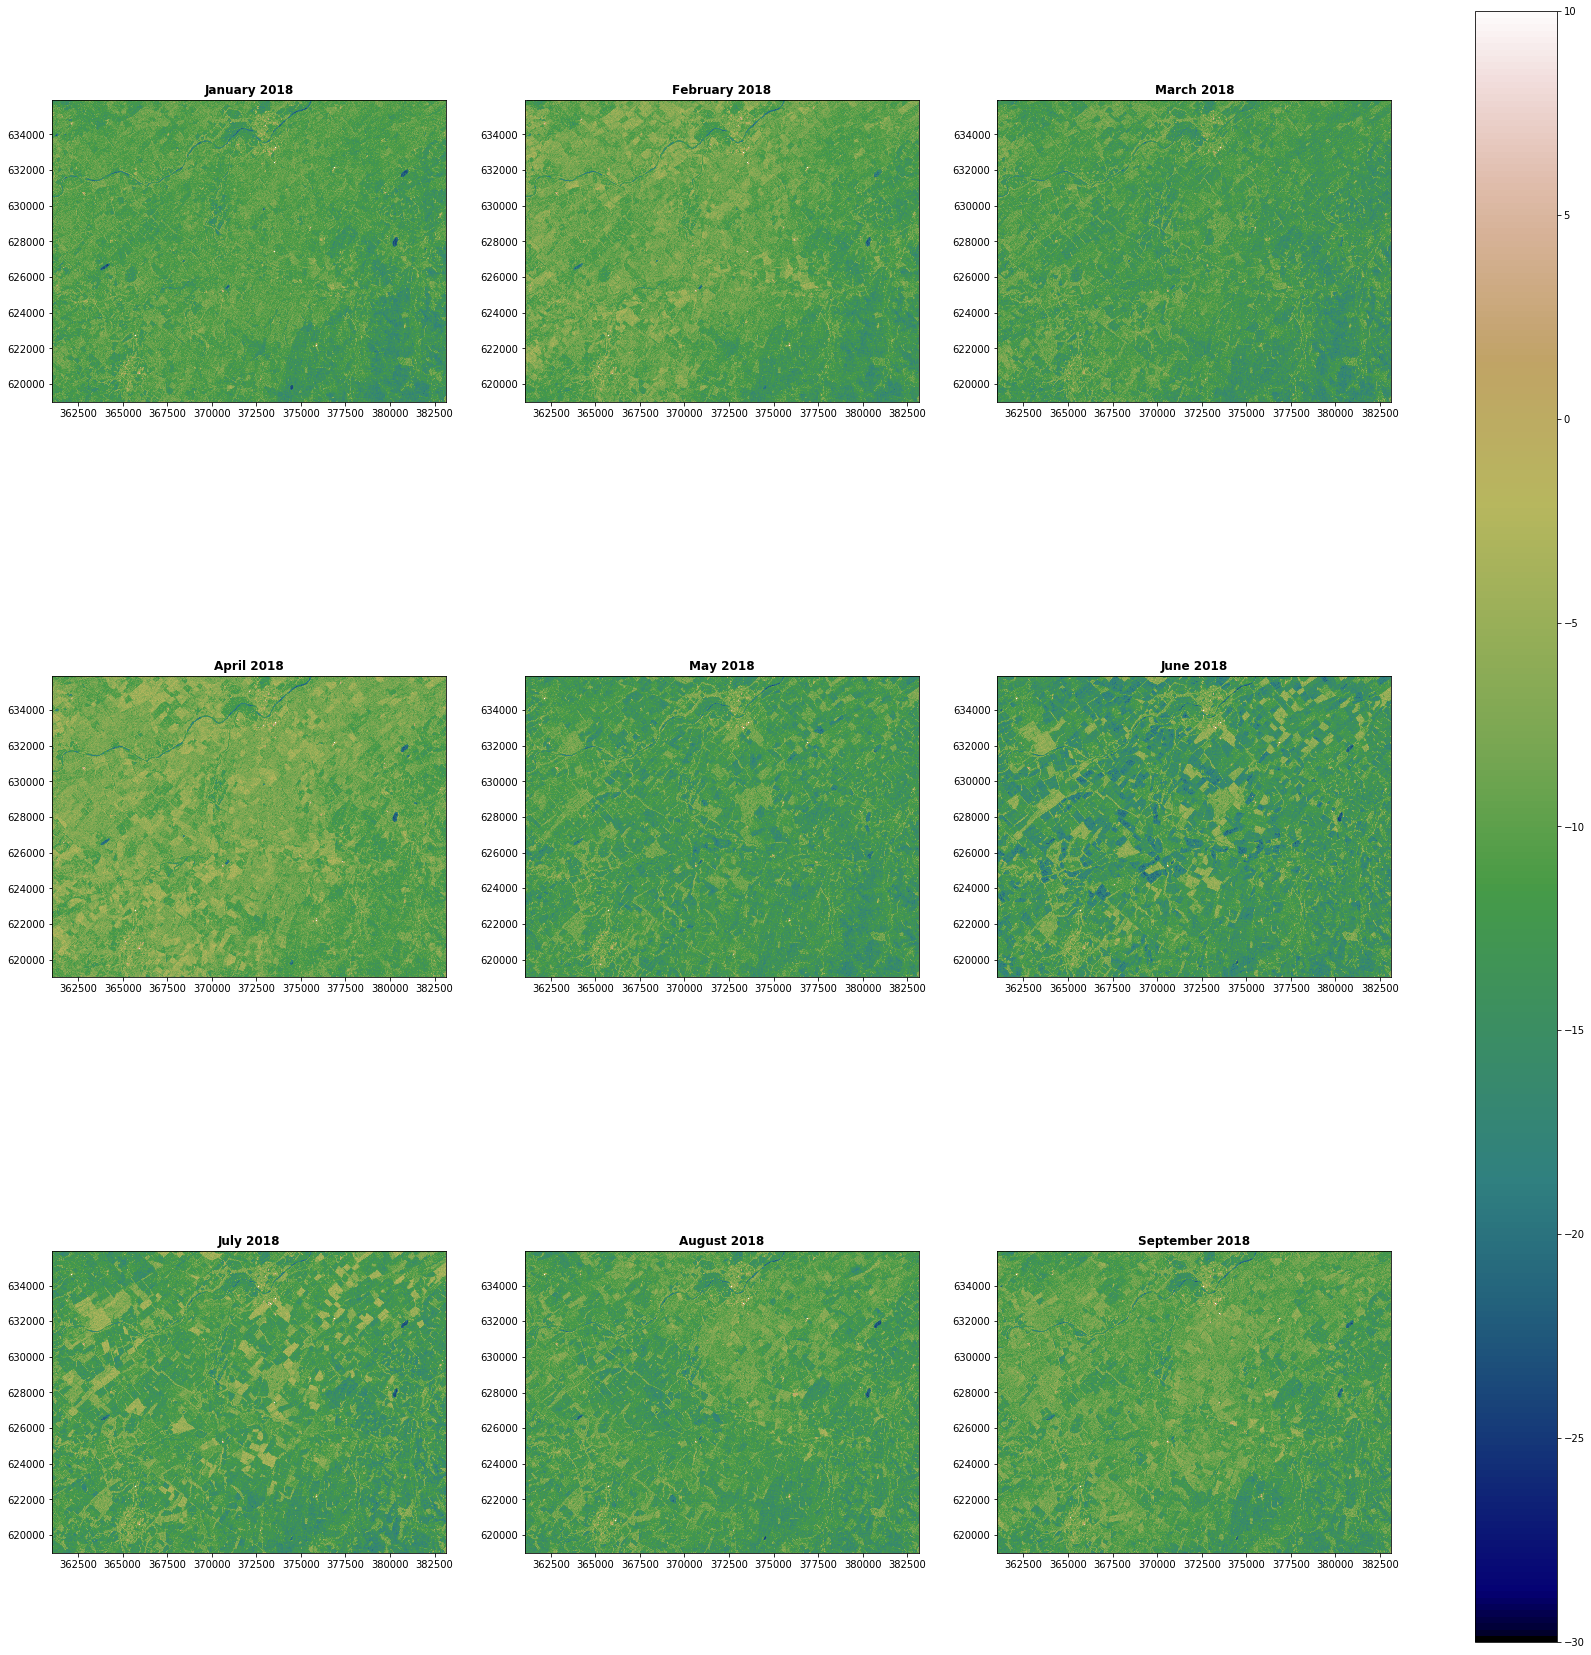

In [8]:
fig, axes = pyplot.subplots(3, 3, figsize=(30,30))

# This fake image is just to be able to build a common color bar
# There is probably a nicer way to do it
fake_image = axes[0][0].imshow(np.random.random((40, 40)),
                  cmap='gist_earth',
                  animated=True,
                  vmin=-30,
                  vmax=10
                 )

for i, file in enumerate(clipped_files, start=0):    
    clipped = rasterio.open(r"data/clipped/"+file)
    row = int(i/3)
    col = i % 3
    show(clipped, ax=axes[row][col], cmap='gist_earth', title=str(in_files[i][1]), vmin=-30, vmax=10)
    
fig.colorbar(fake_image, ax=axes.ravel().tolist(), orientation='vertical')

/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


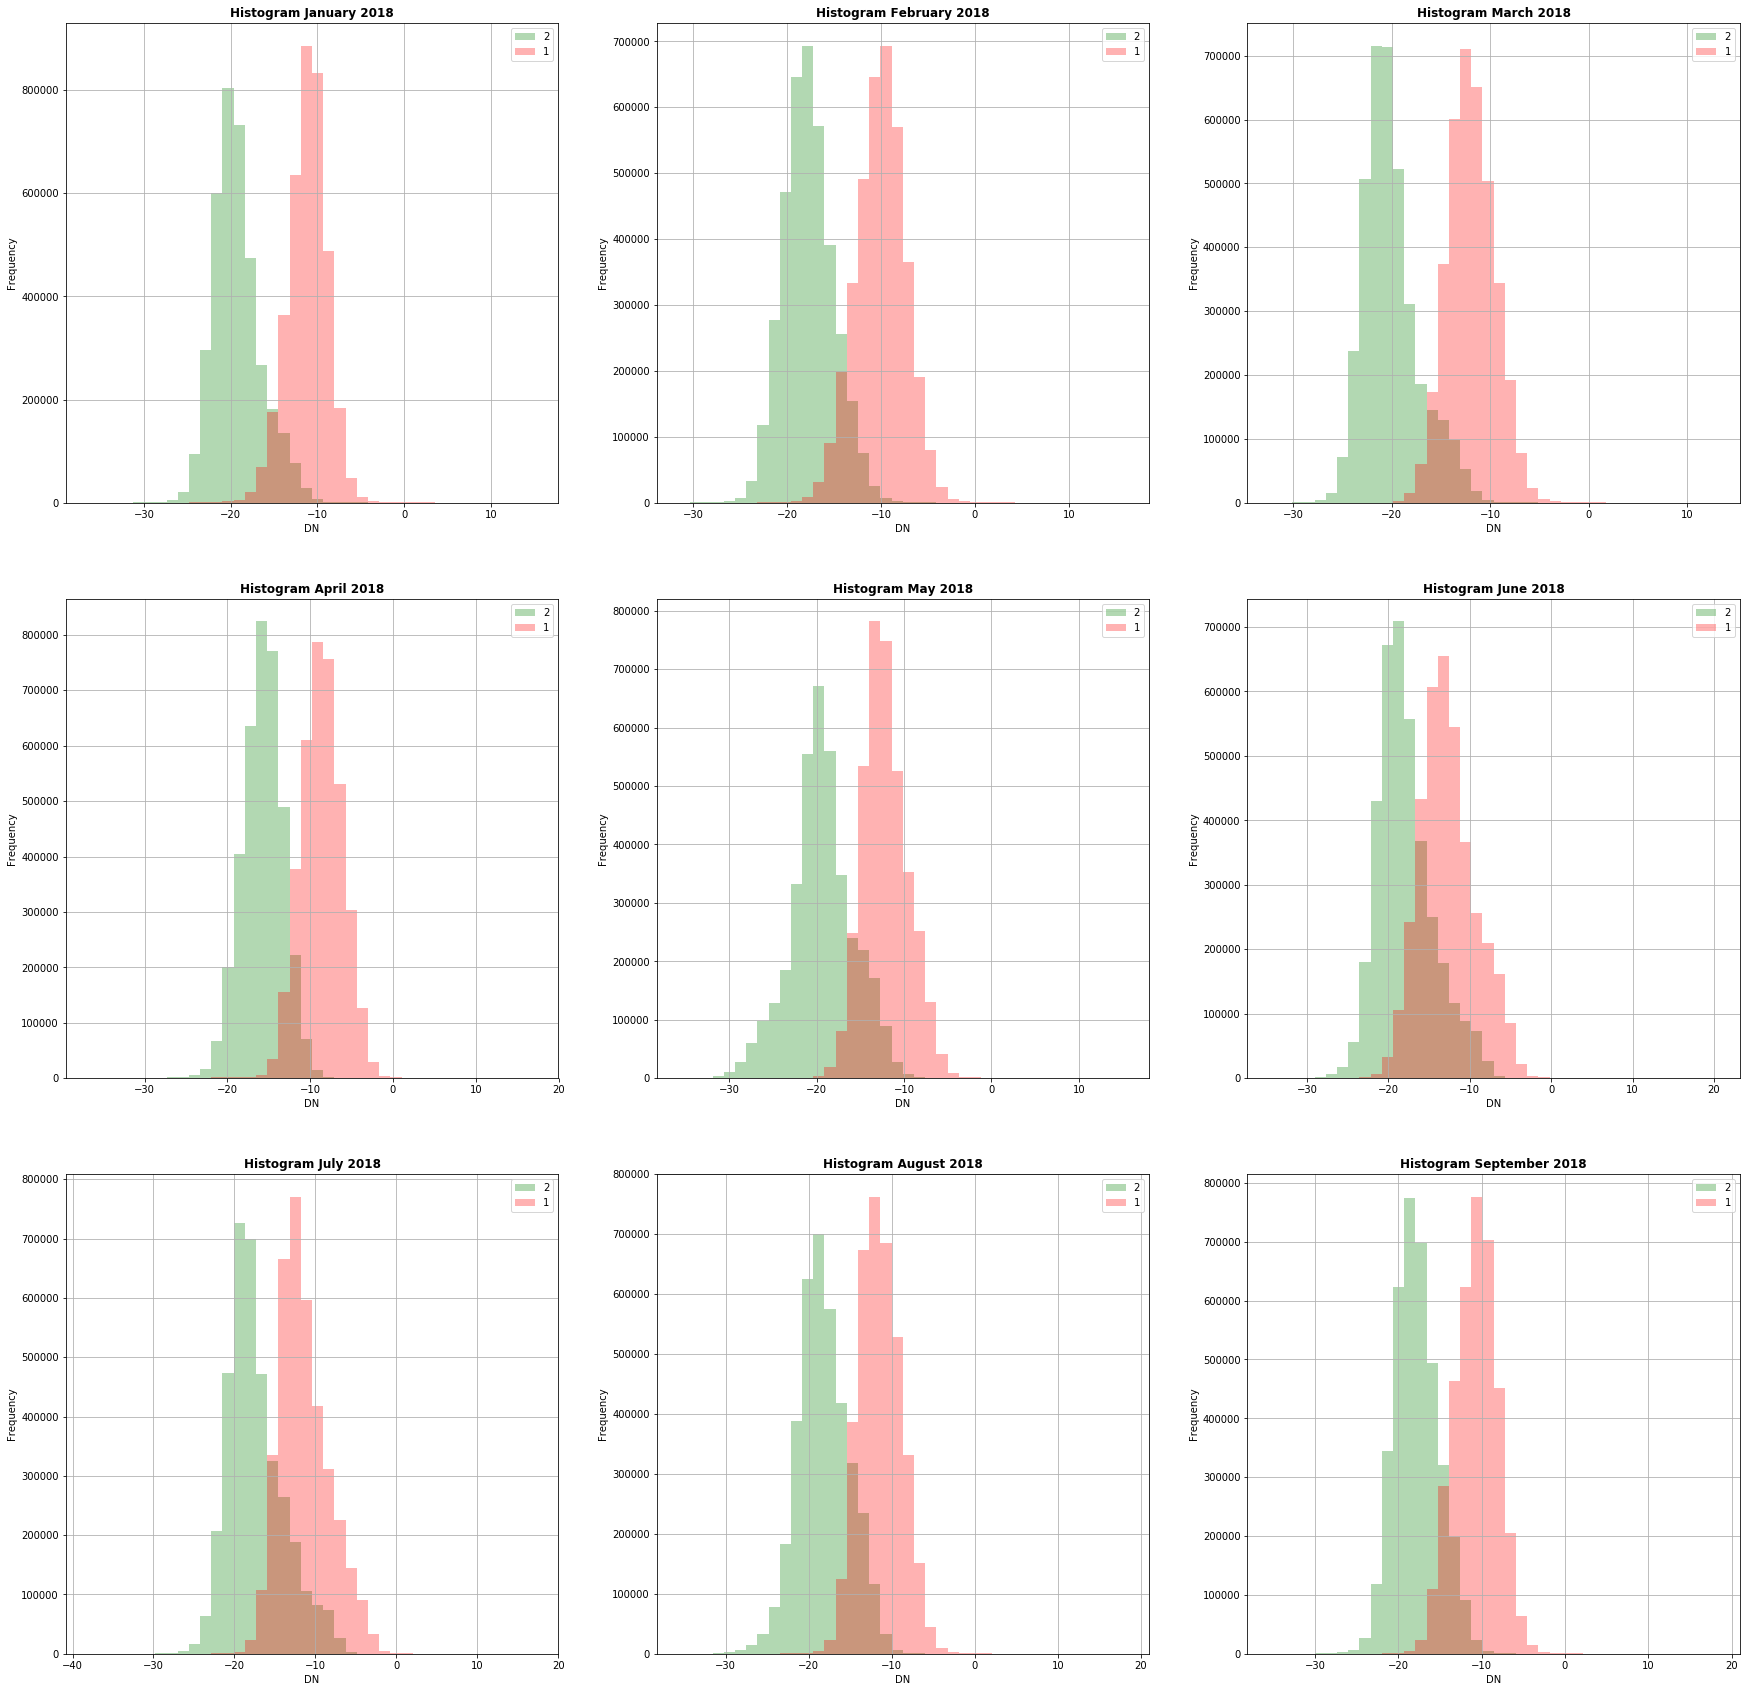

In [11]:
fig, axes = pyplot.subplots(3, 3, figsize=(30,30))

for i, file in enumerate(clipped_files, start=0):
    clipped = rasterio.open(r"data/clipped/"+file)
    row = int(i/3)
    col = i % 3
    show_hist(clipped, ax=axes[row][col], bins=40, lw=0.0, stacked=False, alpha=0.3, 
              histtype='stepfilled', title="Histogram "+str(in_files[i][1]))

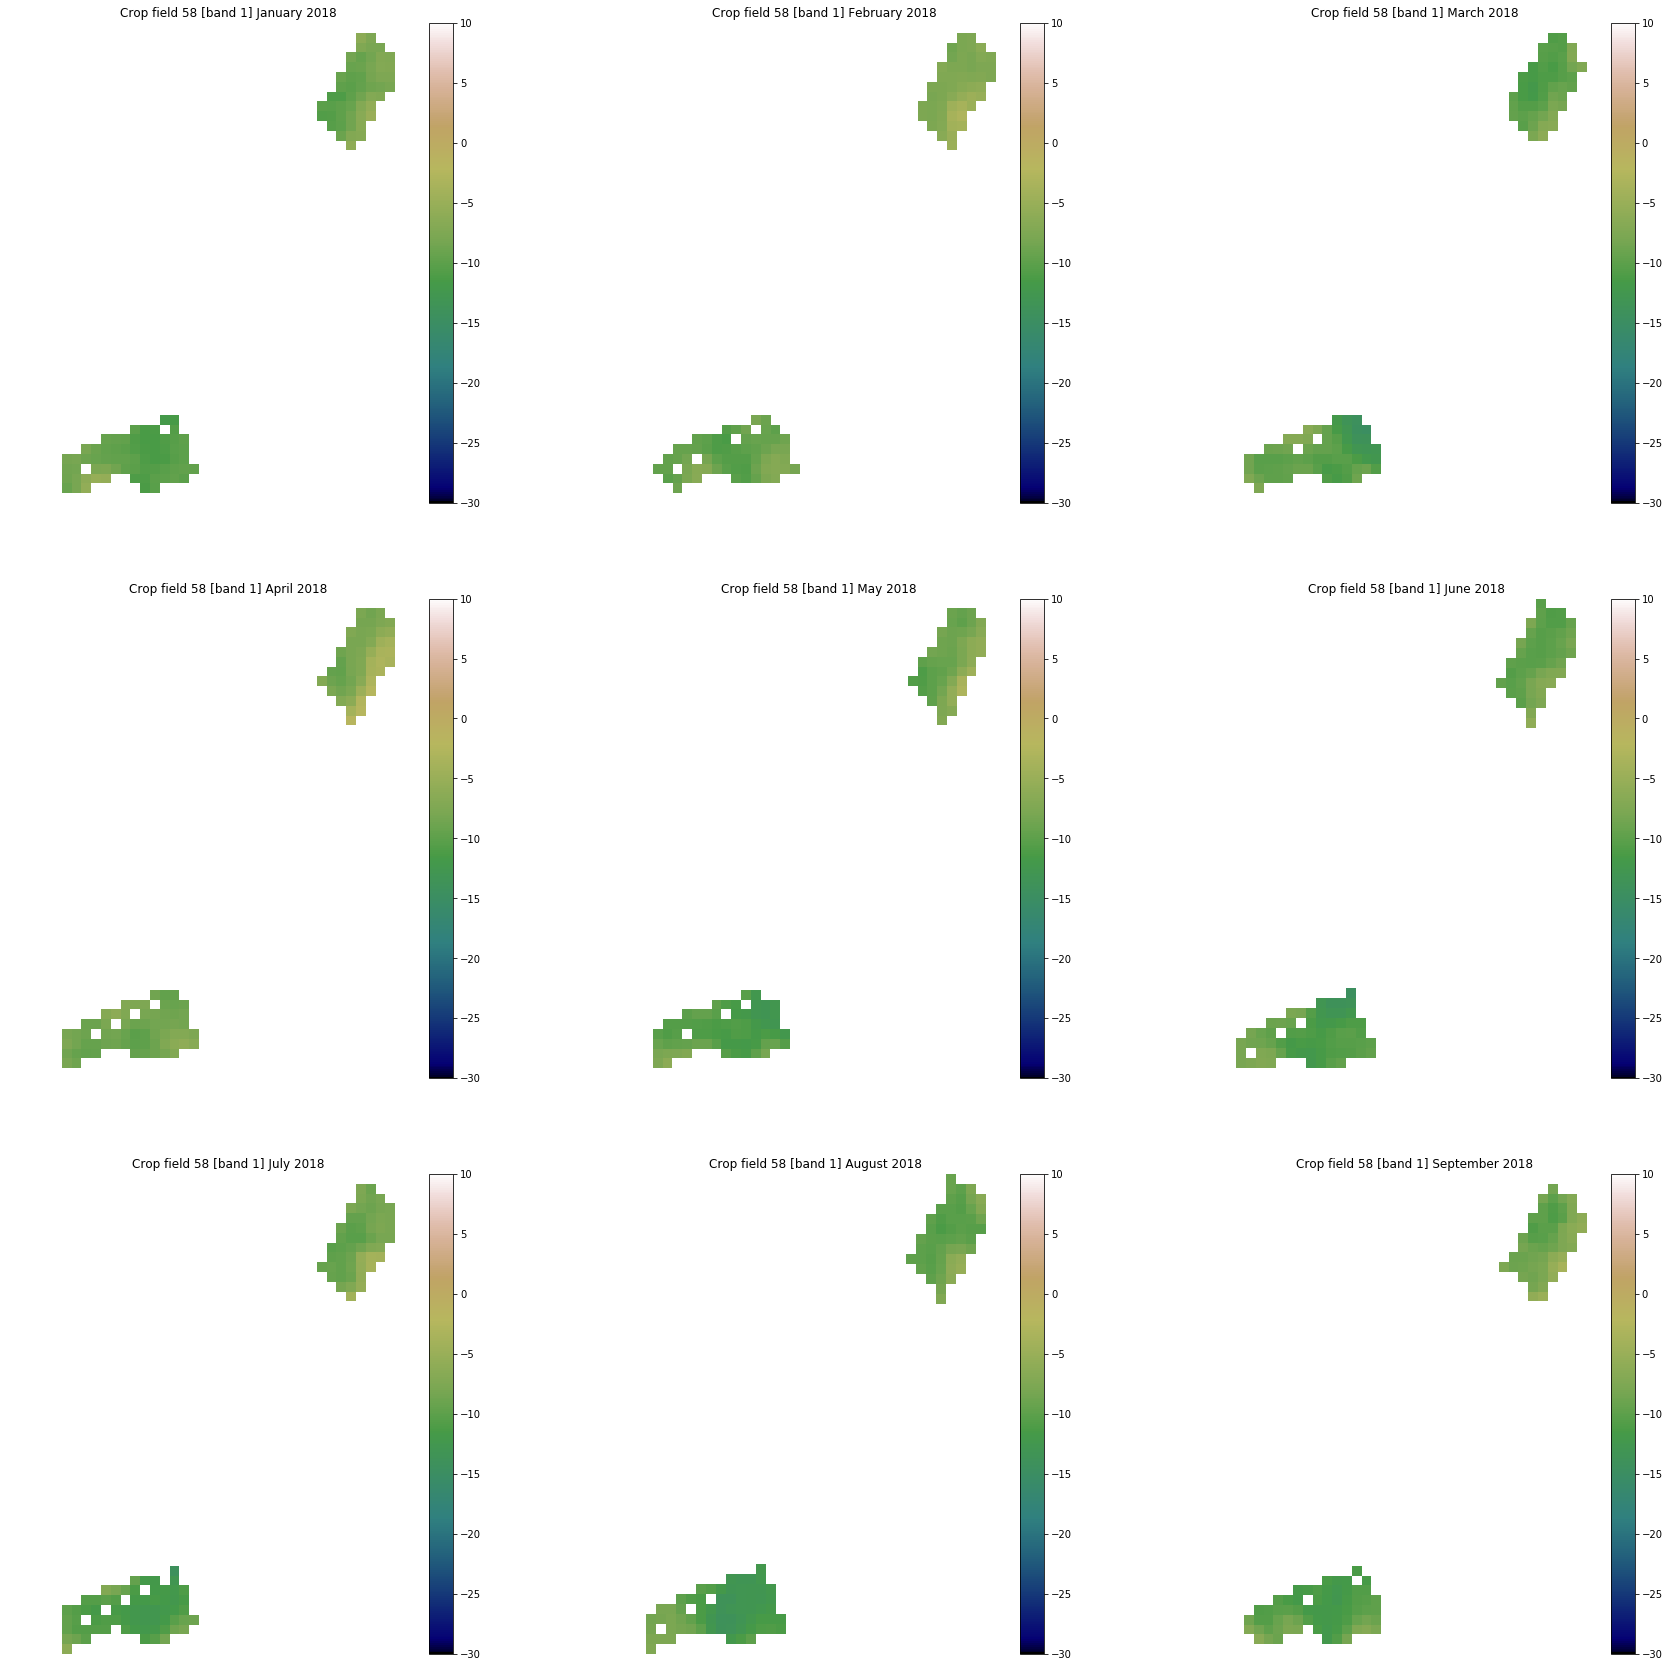

In [12]:
shapefile = gpd.read_file('fields.shp')

# create geojson object from the shapefile imported above
field_geojson = mapping(shapefile['geometry'][field_num])

fig, axes = pyplot.subplots(3, 3, figsize=(30,30))

for i, file in enumerate(clipped_files, start=0):
    clipped = rasterio.open(r"data/clipped/"+file)
    row = int(i/3)
    col = i % 3
    field_crop, field_crop_affine = mask(clipped, [field_geojson], crop=True, indexes=[1])

    # Create spatial plotting extent for the cropped layer
    field_extent = plotting_extent(field_crop[0], field_crop_affine)
    
    # Plot your data
    image = axes[row][col].imshow(field_crop[0],
                                  extent=field_extent,
                                  cmap='gist_earth',
                                  vmin=-30, 
                                  vmax=10)
    
    fig.colorbar(fake_image, ax=axes[row][col], orientation='vertical');
    axes[row][col].set_title("Crop field 58 [band 1] "+str(in_files[i][1]))
    axes[row][col].set_axis_off()


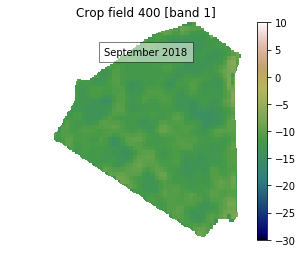

In [25]:
# Setup
#fig = pyplot.figure()

# create geojson object from the shapefile imported above
field_geojson = mapping(shapefile['geometry'][field_num])
shapefile = gpd.read_file('fields.shp')

fig, ax = pyplot.subplots()
ax.set_axis_off()
ax.set_title("Crop field "+str(field_num)+" [band 1]")

title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

image = ax.imshow(np.random.random((40, 40)),
                  cmap='gist_earth',
                  animated=True,
                  vmin=-30,
                  vmax=10
                 )
fig.colorbar(image, ax=ax, orientation='vertical')

def get_image(data):
    file, timestamp = data
    
    # simulate new data coming in
    clipped = rasterio.open(r"data/clipped/"+file)
    
    field_crop, field_crop_affine = mask(clipped, [field_geojson], crop=True, indexes=[1])

    # Create spatial plotting extent for the cropped layer
    field_extent = plotting_extent(field_crop[0], field_crop_affine)
    
    # Plot your data
    image = ax.imshow(field_crop[0],
                      extent=field_extent,
                      cmap='gist_earth',
                      animated=True,
                      vmin=-30,
                      vmax=10
                     )
    
    # fig.colorbar(image, ax, orientation='vertical');
    # print(timestamp)
    title.set_text(timestamp)
    return image, title

def animGen():
    for i, file in enumerate(clipped_files, start=0):
        yield file, in_files[i][1]
                
anim = FuncAnimation(fig, get_image, frames=animGen, interval=500, blit=True)
anim.save("timelaps.gif", dpi = 80, writer='imagemagick')

rc('animation', html='jshtml')

HTML(anim.to_jshtml())